# SPECTRAL TIMING PRODUCTS

This tutorial shows how nDspec handles standard spectral-timing products

In [1]:
import sys
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from pyfftw.interfaces.numpy_fft import (
    fftfreq,
)
from astropy.io import fits

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

from ndspec.Response import ResponseMatrix
from ndspec.Timing import PowerSpectrum, CrossSpectrum
import ndspec.models as models

## The PowerSpectrum class

The power spectrum (or psd) is one of the simplest timing products used in astronomy. In nDspec, it is handled by a dedicated class, ````PowerSpectrum````. This class requires an array of times to be instantiated, at which time the array of (positive) Fourier frequencies ````freqs```` corresponding to the input time array is also computed and stored. After instantiation, users can pass a time domain model array through the ````compute_psd```` method to calculate the power spectrum of that signal. This power spectrum is stored in the ````power_spec```` attribute.

In this example, our model is a sin function with a period of 2 Hz. Mathematically, the PSD of a sin wave is a delta function peaking at the frequency of the sin wave. We can plot the power spectrum stored in ````power_spec```` with the ````plot_psd```` method - note that our plot does not quite resemble a delta function! This is because utilizing a Fast Fourier transform results in windowing effects which "leak" some of the power across many frequencies. Note however that in this case, the leaked power is orders of magnitude below the 2Hz peak we were expecting.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


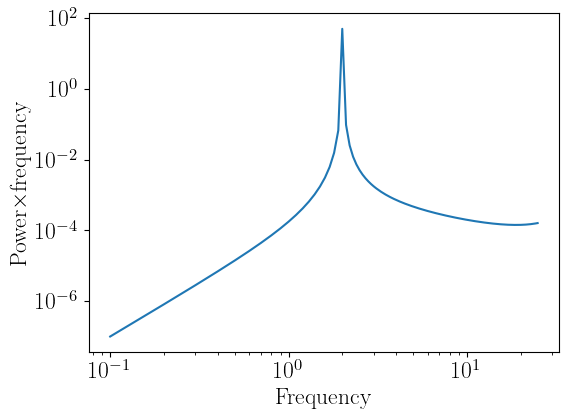

6842

In [2]:
#let us define a grid of 500 time bins, from 0 to 10.
time_res = 500
times = np.linspace(0,10,time_res)
time_bin = np.diff(times)[0]

#from the time grid we just defined, let us define a sinusoidal wave at a frequency of 2Hz
sin_signal = np.sin(2.*np.pi*times/0.5)

#finally, let us initialize our PowerSpectrum object, compute the PSD of our sin wave, and plot the result.
sin_psd = PowerSpectrum(times)
sin_psd.compute_psd(sin_signal)
sin_psd.plot_psd()
gc.collect()

It is common for models to be defined in the Fourier, rather than time, domain. In this example we will build such a model, similar to those used for studying accreting black holes.

First, we define a longer array of times, since accreting sources display variability over a wide array of timescales. We then define our model as a sum of two Lorentzian functions, using the ````lorentz```` function from ````nDspec.models````. The first argument of each Lorentzian is the Fourier frequency grid over which the function is defined - in this case, it will be the ````freqs```` method stored in the ````psd_model```` ````PowerSpectrum```` object. The second argument is an array of parameters for each Lorentzian - in order, the centroid frequency, Q factor, and rms normalization. We can then assign the sum of the two Lorentzians direcetly to the ````power_spec```` method and plot the result. Because the model is defined in Fourier space, there is no need to call the ````compute_psd```` method to Fourier transform the input.

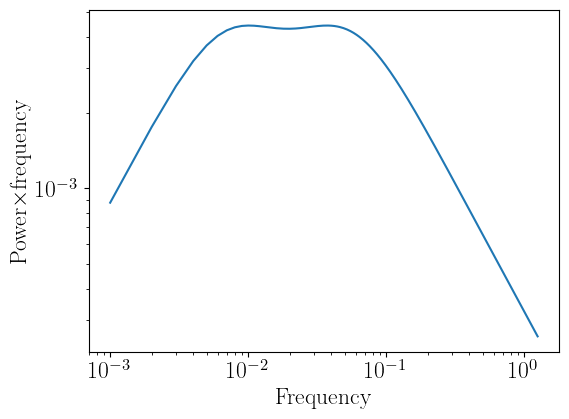

9967

In [3]:
#Define our time grid and power spectrum object
time_res_fft = 2500+1
times_fft = np.linspace(0.1,1.e3,time_res_fft)
psd_model_fft = PowerSpectrum(times_fft)

#Define our model for the power spectrum directly in Fourier space, as a sum of two Lorentzians
centroid_1 = 0.0075
q_1 = 0.1
rms_1 = 0.1
centroid_2 = 0.05
q_2 = 0.1
rms_2 = 0.1
lorentz_fft = models.lorentz(psd_model_fft.freqs,np.array([centroid_1,q_1,rms_1])) + \
              models.lorentz(psd_model_fft.freqs,np.array([centroid_2,q_2,rms_2]))  

#Assign the model array to power_spec and plot the result
psd_model_fft.power_spec = lorentz_fft
psd_model_fft.plot_psd()
gc.collect()

## The CrossSpectrum class

more

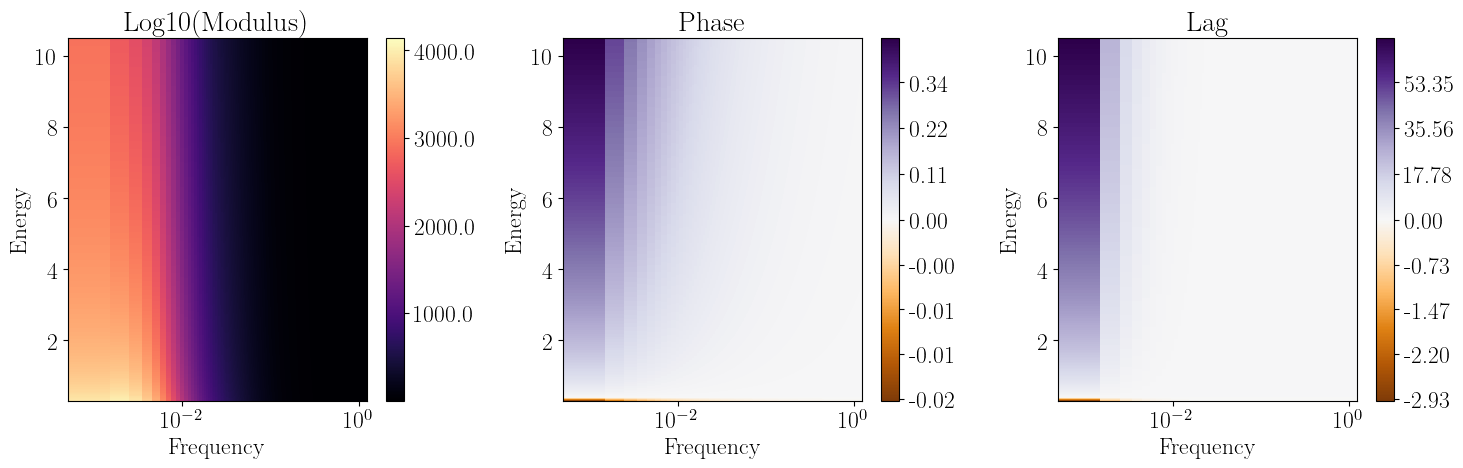

15632

In [4]:
#read the NICER response to set up an identical energy array
NICER_rmf = os.getcwd()+"/data/nicer-rmf6s-teamonly-array50.rmf"
response = fits.open(NICER_rmf)
# get all the extension names
extnames = np.array([h.name for h in response])
if "MATRIX" in extnames:
    h = response["MATRIX"]
elif "SPECRESP MATRIX" in extnames:
    h = response["SPECRESP MATRIX"]
data = h.data
energ_lo = np.array(data.field("ENERG_LO"))
energ_hi = np.array(data.field("ENERG_HI"))
nicer_en = (energ_lo+energ_hi)/2.
energy_channels=len(nicer_en)
response.close()

ref_emin = nicer_en[0]
ref_emax = nicer_en[-1]

piv_fft = CrossSpectrum(times_fft,energ=nicer_en,method='fft')

piv_transfer = models.pivoting_pl(piv_fft.freqs,nicer_en,np.array([1.,-1.9,0.2,-0.5,-0.6,piv_fft.freqs[0]]))
piv_fft.set_psd_weights(psd_model_fft.power_spec)
piv_fft.set_transfer(piv_transfer)
piv_fft.set_reference_energ([ref_emin,ref_emax])
piv_fft.cross_from_transfer()
piv_fft.plot_cross_2d()
gc.collect()

29981

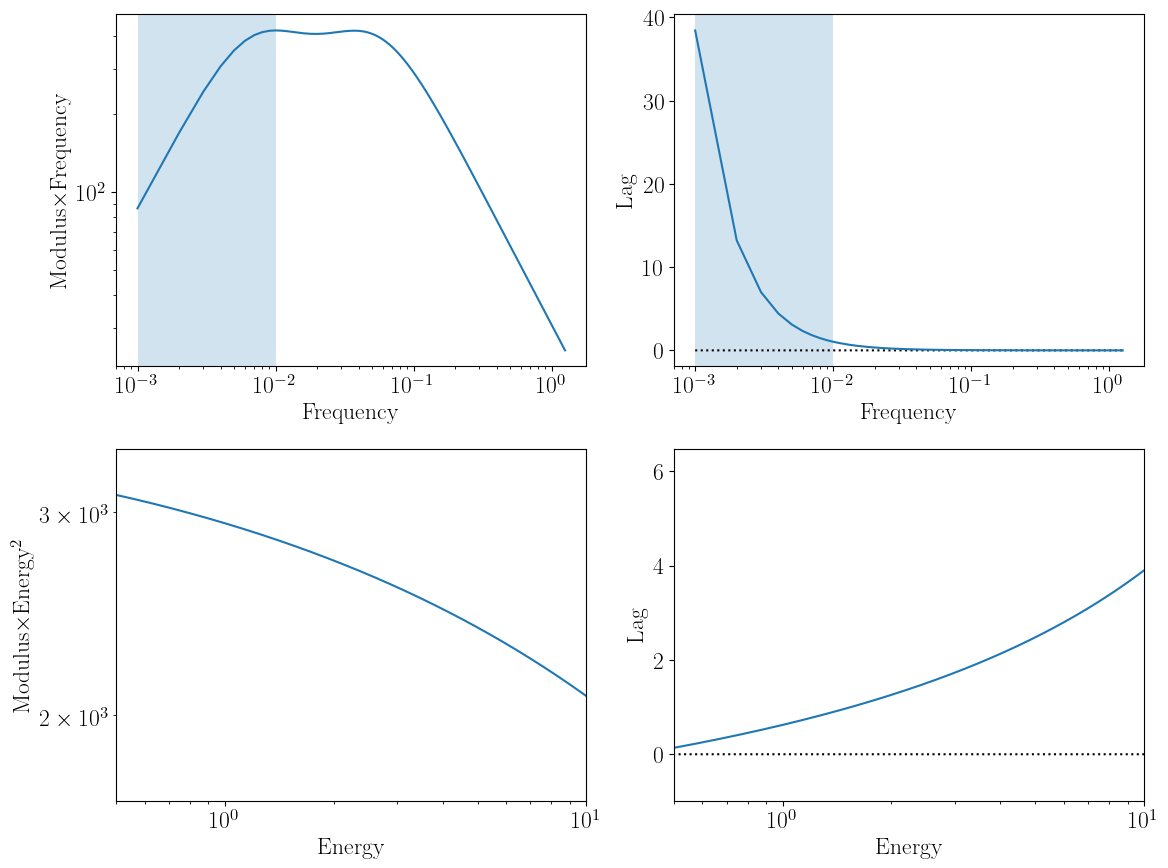

In [14]:
bounds = [3.,5.]

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12.,9.))

ax1.axvspan(piv_fft.freqs[0],10.*piv_fft.freqs[0],alpha=0.2)
ax1.plot(piv_fft.freqs,piv_fft.mod_frequency(bounds)*piv_fft.freqs)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Modulus$\\times$Frequency")

ax2.axvspan(piv_fft.freqs[0],10.*piv_fft.freqs[0],alpha=0.2)
ax2.plot(piv_fft.freqs,np.zeros(piv_fft.n_freqs),color='black',linestyle='dotted')
ax2.plot(piv_fft.freqs,piv_fft.lag_frequency(bounds))

ax2.set_xscale("log")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Lag")

ax3.plot(piv_fft.energ,piv_fft.mod_energy(nu_min=piv_fft.freqs[0],nu_max=10.*piv_fft.freqs[0])*piv_fft.energ**2)

ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("Energy")
ax3.set_ylabel("Modulus$\\times$Energy$^{2}$")
ax3.set_xlim([0.5,10])

ax4.plot(piv_fft.energ,np.zeros(piv_fft.n_chans),color='black',linestyle='dotted')
ax4.plot(piv_fft.energ,piv_fft.lag_energy(nu_min=piv_fft.freqs[0],nu_max=10.*piv_fft.freqs[0]))

ax4.set_xscale("log")
ax4.set_xlabel("Energy")
ax4.set_ylabel("Lag")
ax4.set_xlim([0.5,10])

plt.tight_layout()
gc.collect()

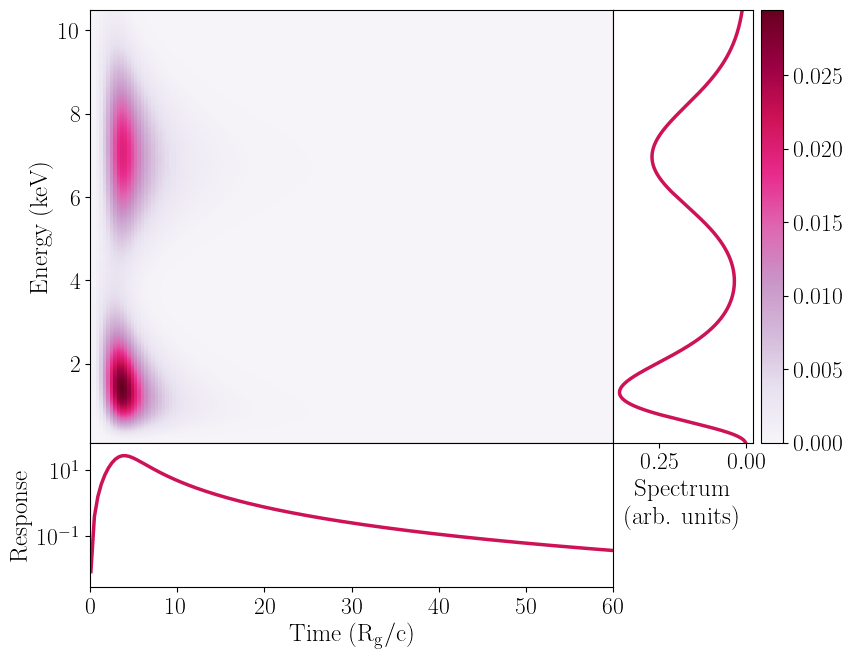

8640898

In [6]:
#tbd: add explanation of each parameter in the full notebook
gauss_flash, gauss_line, gauss_pulse = models.gauss_bkn(times_fft,nicer_en,np.array([3e-3,2.,6.5,2.,-3.,4.,-0.25]))
bb_flash, bb_spec, bb_pulse = models.bbody_bkn(times_fft,nicer_en,np.array([1.5e-3,0.5,2,-3.,4.,-0.25]))  

rev_flash = gauss_flash + bb_flash
rev_spec = gauss_line + bb_spec
rev_pulse = gauss_pulse + bb_pulse

models.plot_2d(times_fft,nicer_en,rev_flash,rev_pulse,rev_spec,xlim=[0,60])
gc.collect()

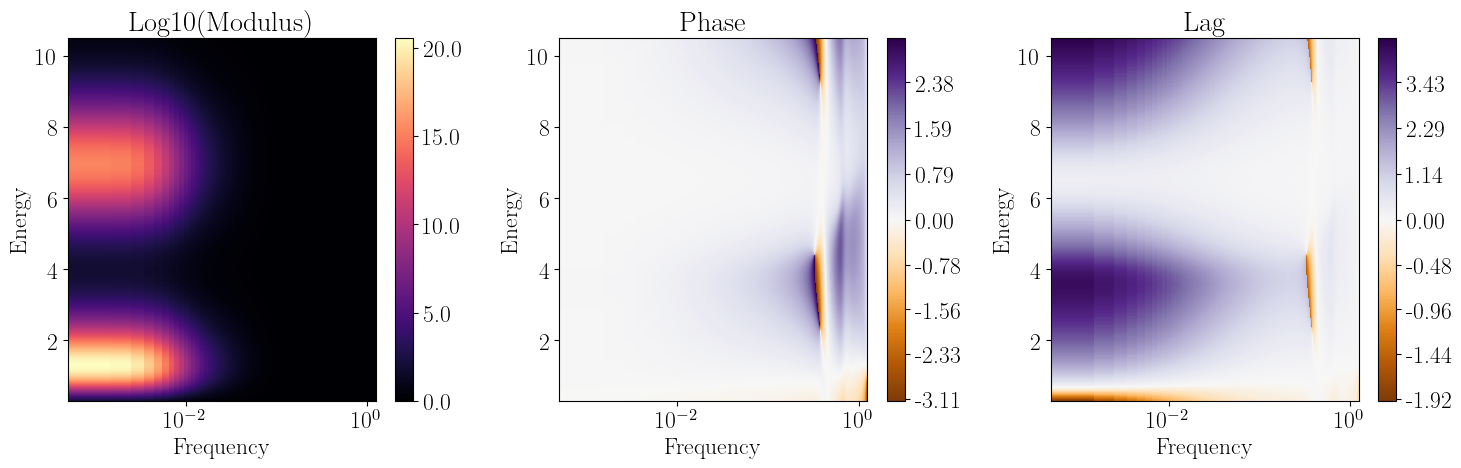

15588

In [7]:
rev_fft = CrossSpectrum(times_fft,energ=nicer_en,method='fft')
rev_fft.set_psd_weights(psd_model_fft.power_spec)
rev_fft.set_impulse(rev_flash)
rev_fft.set_reference_energ([ref_emin,ref_emax])
rev_fft.cross_from_irf()
rev_fft.plot_cross_2d()
gc.collect()

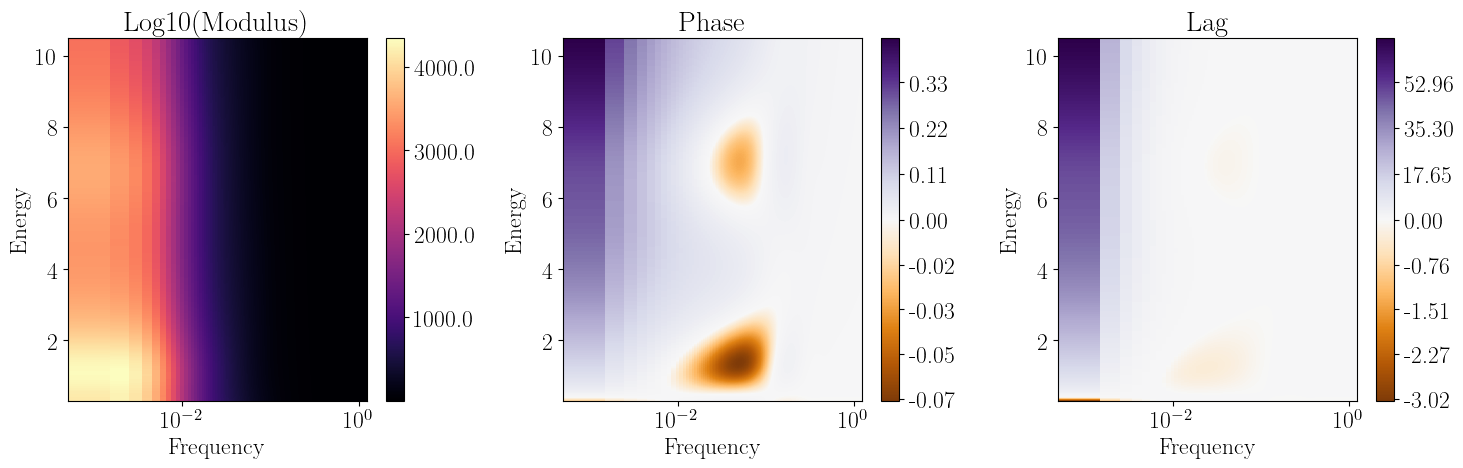

15574

In [8]:
full_fft = CrossSpectrum(times_fft,energ=nicer_en,method='fft')
full_fft.set_psd_weights(psd_model_fft.power_spec)
full_fft.set_transfer(piv_fft.trans_func + rev_fft.trans_func)
full_fft.set_reference_energ([ref_emin,ref_emax])
full_fft.cross_from_transfer()
full_fft.plot_cross_2d()
gc.collect()

29716

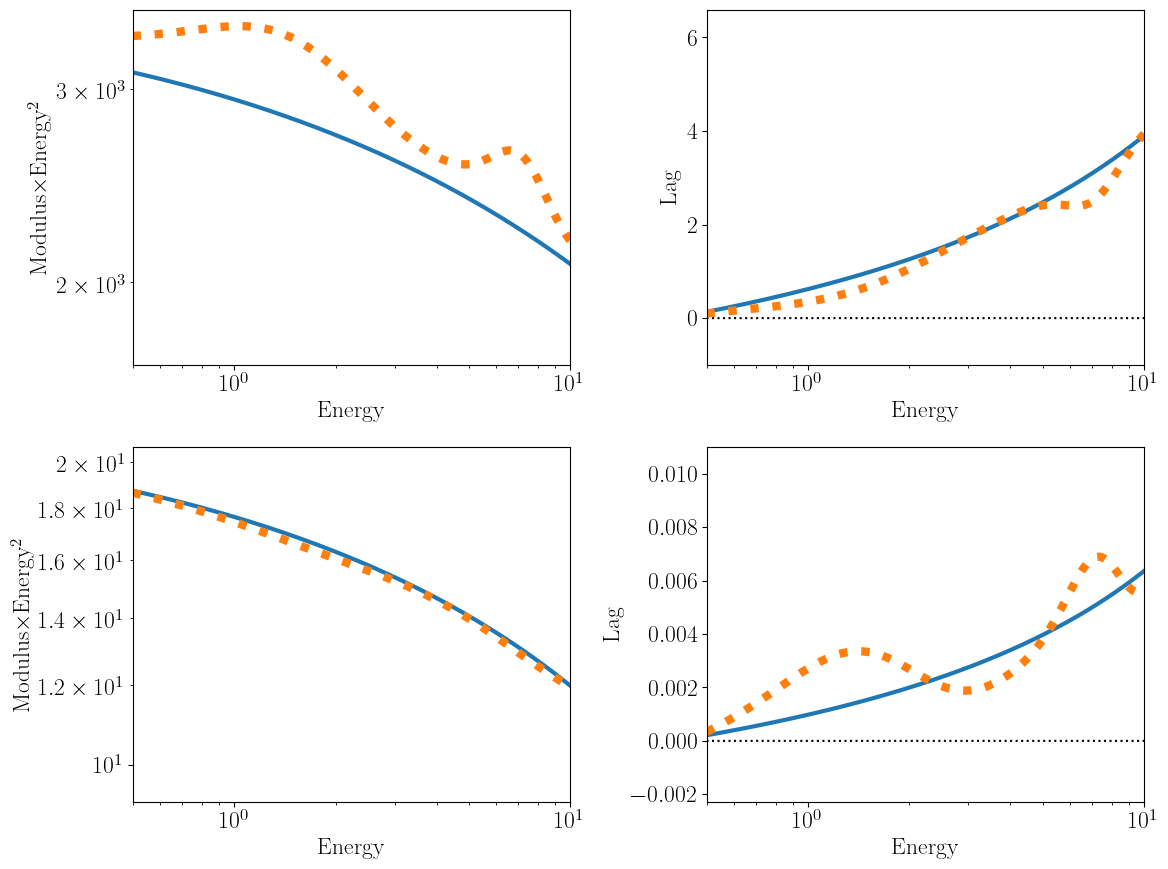

In [9]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12.,9))

ax1.plot(piv_fft.energ,piv_fft.mod_energy(nu_min=piv_fft.freqs[0],nu_max=10.*piv_fft.freqs[0])*piv_fft.energ**2,
         linewidth=3)
ax1.plot(full_fft.energ,full_fft.mod_energy(nu_min=full_fft.freqs[0],nu_max=10.*full_fft.freqs[0])*full_fft.energ**2,
         linewidth=6,linestyle='dotted')

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Energy")
ax1.set_ylabel("Modulus$\\times$Energy$^{2}$")
ax1.set_xlim([0.5,10])

ax2.plot(piv_fft.energ,np.zeros(piv_fft.n_chans),color='black',linestyle='dotted')
ax2.plot(piv_fft.energ,piv_fft.lag_energy(nu_min=piv_fft.freqs[0],nu_max=10.*piv_fft.freqs[0]),linewidth=3)
ax2.plot(full_fft.energ,full_fft.lag_energy(nu_min=full_fft.freqs[0],nu_max=10.*full_fft.freqs[0]),
         linewidth=6,linestyle='dotted')

ax2.set_xscale("log")
ax2.set_xlabel("Energy")
ax2.set_ylabel("Lag")
ax2.set_xlim([0.5,10])

ax3.plot(piv_fft.energ,piv_fft.mod_energy(nu_min=0.1*piv_fft.freqs[-1],nu_max=0.5*piv_fft.freqs[-1])*piv_fft.energ**2,
         linewidth=3)
ax3.plot(full_fft.energ,full_fft.mod_energy(nu_min=0.1*full_fft.freqs[-1],nu_max=0.5*full_fft.freqs[-1])*full_fft.energ**2,
         linewidth=6,linestyle='dotted')

ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("Energy")
ax3.set_ylabel("Modulus$\\times$Energy$^{2}$")
ax3.set_xlim([0.5,10])

ax4.plot(piv_fft.energ,np.zeros(piv_fft.n_chans),color='black',linestyle='dotted')
ax4.plot(piv_fft.energ,piv_fft.lag_energy(nu_min=0.1*piv_fft.freqs[-1],nu_max=0.5*piv_fft.freqs[-1]),linewidth=3)
ax4.plot(full_fft.energ,full_fft.lag_energy(nu_min=0.1*full_fft.freqs[-1],nu_max=0.5*full_fft.freqs[-1]),
         linewidth=6,linestyle='dotted')

ax4.set_xscale("log")
ax4.set_xlabel("Energy")
ax4.set_ylabel("Lag")
ax4.set_xlim([0.5,10])

plt.tight_layout()
gc.collect()

Arf missing, please load it
Arf loaded


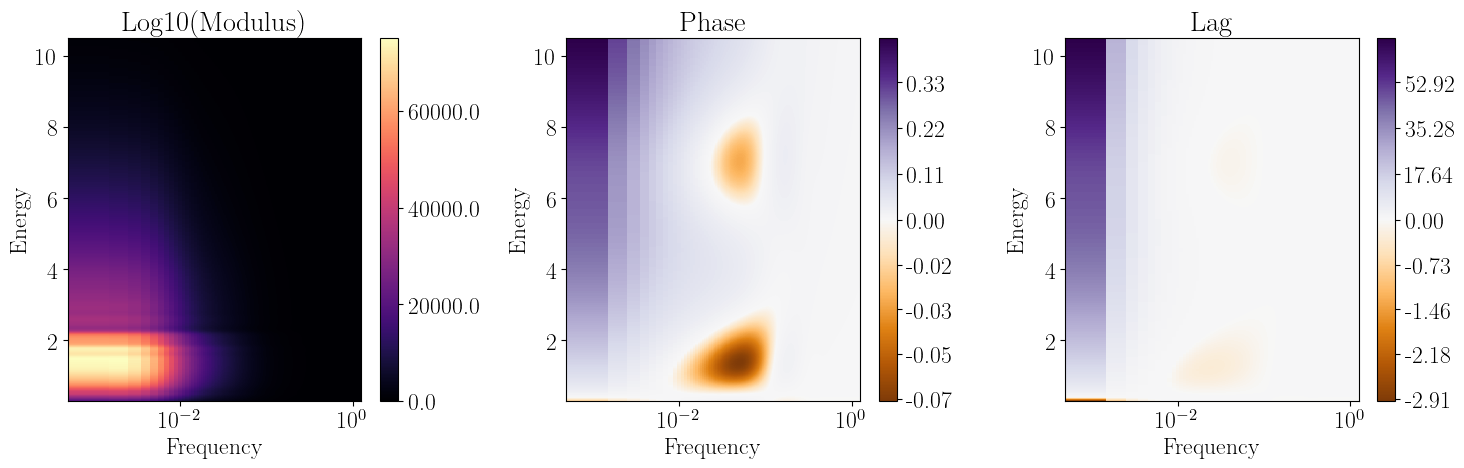

15799

In [10]:
rmfpath = os.getcwd()+"/data/nicer-rmf6s-teamonly-array50.rmf"
nicer_matrix = ResponseMatrix(rmfpath)
arfpath = os.getcwd()+"/data/nicer-consim135p-teamonly-array50.arf"
nicer_matrix.load_arf(arfpath)

convolved_model = nicer_matrix.convolve_response(full_fft)
convolved_model.plot_cross_2d()
gc.collect()

In [11]:
print(full_fft.cross.shape,convolved_model.cross.shape)

(3451, 1250) (1501, 1250)
